In [1]:
## import needed mods
import pandas as pd, numpy as np, scipy.stats as ss, seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from PIL import Image
from matplotlib import pyplot as plt 
plt.style.use(['tableau-colorblind10'])

%matplotlib inline

In [2]:
## Write needed ftns for analysis
def allelic_ANOVA(site, pheno):
    """This regression is equivalent to one-way ANOVA with 2 groups. Return F-statistic.

    Assumes site is coded as -1, 1
    """
    coding = np.array(site,np.float)
    pheno = np.array(pheno,np.float)

    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F


def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

In [3]:
## set path and bring in genotype data
geno_path = '../DATA/GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
geno_df = pd.read_csv(geno_path)

In [4]:
## View frist 5 rows of chromosome 14 data
geno_df[(geno_df.Chrom=='Chr14')].head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382
88605,Chr14,6648,146846.0,1.0,T,G,1,8809,snp,230,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
88606,Chr14,15301,89905.0,1.0,CTTTTTTTTTTTAAAAAAAAGGT,CTTTTTTTTTTAAAAAAAAAGGT,1,6238,indel,348,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
88607,Chr14,24175,156761.0,1.0,C,T,1,9515,snp,531,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
88608,Chr14,28073,139655.0,1.0,CA,CG,1,8586,indel,619,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
88609,Chr14,28198,139875.0,1.0,TTACA,TTACG,1,8498,indel,624,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0


In [5]:
## Set gff path and bring in data
gff_path = '../DATA/xl280genome.gff3.csv.gz'
gff = pd.read_csv(gff_path,index_col=0)

## Check data for gene CNN01270 ie RIC8
gff[(gff.id == 'CNN01270')]

,type,gene,start,end,strand,contig,phase,attribute,description,id
53405,gene,CNN01270,386833,389699,+,Chr14,.,ID=CNN01270;description=hypothetical protein,hypothetical protein,CNN01270


In [6]:
## View variants within RIC8
geno_df[(geno_df.Chrom=='Chr14') & 
        (geno_df.Pos>=386833) & 
        (geno_df.Pos<=389699)].head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382
90523,Chr14,386898,117375.0,1.0,G,A,1,7300,snp,10980,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
90524,Chr14,386995,131484.0,1.0,T,A,1,8331,snp,10984,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
90525,Chr14,387211,157752.0,1.0,T,G,1,9574,snp,10990,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
90526,Chr14,387317,163742.0,1.0,A,G,1,9883,snp,10991,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
90527,Chr14,387368,166211.0,1.0,G,T,1,9840,snp,10992,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [7]:
## Define chromosomes
chrlist = sorted(geno_df.Chrom.unique())
len(chrlist)

14

In [8]:
## Gather the length of each chromosome
clens = [geno_df[(geno_df.Chrom==chrom)]['Pos'].max() 
         for chrom in chrlist]

In [9]:
## Set mid points
chrom_midpts = 0.5 * np.sum(np.array([a 
                    for a in zip([0]+list(np.cumsum(clens)),
                            np.cumsum(clens))]),axis=1)
cumpos = [0] + list(np.cumsum(clens))[:-1]

In [10]:
## Set path for phenotype data
file_path = '../DATA/PHENOTYPE/H2O2/H2O2_scores.csv'

In [11]:
## Bring in H2O2 data check shape
h2O2 = pd.read_csv(file_path)
h2O2.shape

(480, 9)

In [12]:
## Check plate names
sorted(h2O2.Plate.unique())

[1, 2]

In [13]:
## view first few rows
h2O2.head()

,Row,Column,Plate,Strain,Scoredm,Scorelh,Plate_name,Replicate_name,Replicate
0,e,7,2,SS-A837,3.0,3.0,qtl2a,a,0
1,e,7,2,SS-A837,2.0,2.0,qtl2b,b,1
2,e,7,2,SS-A837,2.0,2.0,qtl2c,c,2
3,e,7,2,SS-A837,2.0,2.0,qtl2d,d,3
4,b,2,2,SS-B307,2.0,2.0,qtl2a,a,0


In [14]:
## Take LH scores into a dataframe
h2O2lh = h2O2[['Row','Column','Plate','Scorelh','Strain','Replicate']].copy()
h2O2lh['Score'] = h2O2lh.Scorelh
h2O2lh.drop('Scorelh',axis=1,inplace=True)
h2O2lh['Marker'] = 'LH'

## Take DM scores into dataframe
h2O2dm = h2O2[['Row','Column','Plate','Scoredm','Strain','Replicate']].copy()
h2O2dm['Score'] = h2O2dm.Scoredm
h2O2dm.drop('Scoredm',axis=1,inplace=True)
h2O2dm['Marker'] = 'DM'

In [15]:
## Make scores into arraryas
dmm = h2O2dm.dropna().groupby('Strain').agg(np.median).Score
lhm = h2O2lh.dropna().groupby('Strain').agg(np.median).Score

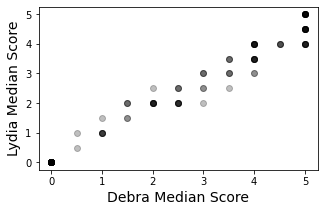

In [16]:
## Compare scorer H2O2 phenotypes
fig,ax = plt.subplots(1,1,figsize=(5,3),sharex=True,sharey=True)
plt.plot(dmm.values,
         lhm.values,'ko',alpha=0.25);
plt.xlabel('Debra Median Score',fontsize=14);
plt.ylabel('Lydia Median Score',fontsize=14);

In [17]:
## Check rank corr with older plates
ss.spearmanr(dmm.values,lhm.values)
## B/c the old plates seem to introduce more variation
## we will droped these from analysis

SpearmanrResult(correlation=0.9803019694515043, pvalue=2.870340990903693e-84)

In [18]:
## Run correlation analysis on DM scores
dm_scores = [a[1].Score.values 
              for a in h2O2dm.sort_values('Strain').groupby('Replicate')]
dm_ranks = []
for i, h in enumerate(dm_scores):
    for j, k in enumerate(dm_scores):
        if i != j and i >= j:
            sr = ss.spearmanr(h,k)
            print(i,j,sr);
            dm_ranks.append((i,j,sr[0]))
            
dm_ranks = pd.DataFrame(dm_ranks,columns = ['Rep1','Rep2','Rank'])
dm_ranks.Rank.mean()

1 0 SpearmanrResult(correlation=0.8824224754673616, pvalue=1.8872215723743576e-40)
2 0 SpearmanrResult(correlation=0.8382735261831195, pvalue=7.218697086829466e-33)
2 1 SpearmanrResult(correlation=0.8798313289699106, pvalue=6.31434020507341e-40)
3 0 SpearmanrResult(correlation=0.8395813615484946, pvalue=4.655534474536432e-33)
3 1 SpearmanrResult(correlation=0.9150979272055131, pvalue=2.2822274367867583e-48)
3 2 SpearmanrResult(correlation=0.8775230954417405, pvalue=1.8091561277997454e-39)


0.8721216191360234

In [19]:
## Run correlation analysis on LH scores
lh_scores = [a[1].Score.values 
              for a in h2O2lh.sort_values('Strain').groupby('Replicate')]
lh_ranks = []
for i, h in enumerate(lh_scores):
    for j, k in enumerate(lh_scores):
        if i != j and i >= j:
            sr = ss.spearmanr(h,k)
            print(i,j,sr);
            lh_ranks.append((i,j,sr[0]))
            
lh_ranks = pd.DataFrame(lh_ranks,columns = ['Rep1','Rep2','Rank'])
lh_ranks.Rank.mean()

1 0 SpearmanrResult(correlation=0.8673541006750937, pvalue=1.4689560887082027e-37)
2 0 SpearmanrResult(correlation=0.7916624375240877, pvalue=5.1738200224357864e-27)
2 1 SpearmanrResult(correlation=0.8516224589697897, pvalue=6.757519002247173e-35)
3 0 SpearmanrResult(correlation=0.8637936056338018, pvalue=6.288826185844876e-37)
3 1 SpearmanrResult(correlation=0.9065864091874128, pvalue=4.968393213371251e-46)
3 2 SpearmanrResult(correlation=0.8692193662509846, pvalue=6.74225361688571e-38)


0.858373063040195

In [20]:
## Gather H2O2 scores across scores 
## Do not use older plates
h2O2L = pd.concat([h2O2dm,
                   h2O2lh],
                  axis=0,sort=True)

## Drop missing data (shouldn't be any)
h2O2L.dropna(inplace=True)

## Check tail of df
h2O2L.tail()

,Column,Marker,Plate,Replicate,Row,Score,Strain
475,6,LH,2,3,e,4.0,XL280a
476,5,LH,2,0,e,5.0,XL280alpha
477,5,LH,2,1,e,4.0,XL280alpha
478,5,LH,2,2,e,4.0,XL280alpha
479,5,LH,2,3,e,3.0,XL280alpha


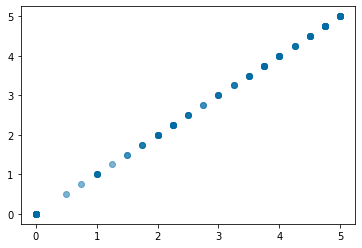

In [21]:
## Dose it make a difference ...
## taking average across replicates than scorer
## or scorer then replicates?
test_scores1 = h2O2L.groupby(['Strain','Replicate']).agg(np.median
                    ).reset_index().groupby(['Strain']).agg(np.median)

test_scores2 = h2O2L.groupby(['Strain','Marker']).agg(np.median
                    ).reset_index().groupby(['Strain']).agg(np.median)

plt.plot(test_scores1.Score,test_scores2.Score,'o',alpha=0.5);

In [22]:
## Are there any that are different from the other?
test_scores1[(test_scores1.Score != test_scores2.Score)] ## no

,Replicate,Column,Plate,Score
Strain,,,,


In [23]:
## Take data for which we have genotype data for
h2O2Ls = h2O2L[(h2O2L.Strain.isin(geno_df.columns))]

## Check shape should be 104
h2O2Ls.Strain.unique().shape

(104,)

In [24]:
## Take median H2O2 growth scores
## first across scorers, then replicates
medh2o2 = h2O2Ls.groupby(['Strain','Marker']).agg(np.median
                    ).reset_index().groupby(['Strain']).agg(np.median)

In [25]:
## segregants used in list
segs = medh2o2.index

In [26]:
## Write labels
_431label = r'$431\mathrm{\alpha}$'
_xl280alabel='XL280'+r'$\bf{a}$'
_xl280alphlabel = r'XL280$\mathrm{\alpha}$'
alpha_label = r'$\mathrm{\alpha}$ = 0.05'

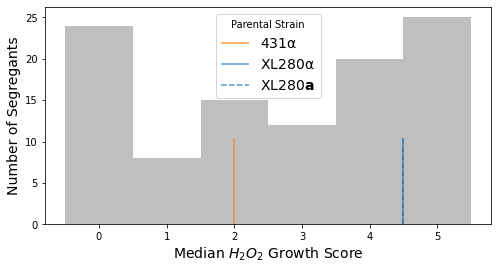

In [27]:
## Show distribution of H2O2 Phenotype
fig,ax=plt.subplots(1,1,figsize=(8,4))
plt.hist(medh2o2.Score.values,color='grey',alpha=0.5,
         bins=np.arange(7)-0.5);
plt.xlabel('Median $H_{2}O_{2}$ Growth Score',fontsize=14);
plt.ylabel('Number of Segregants',fontsize=14);
plt.vlines(medh2o2.T['SS-A837'].T.Score,0,len(segs)/10,
           alpha=0.75,color='tab:orange',label=_431label);
plt.vlines(medh2o2.T['XL280alpha'].T.Score,0,len(segs)/10,
           alpha=0.75,linestyle='-',
           color='tab:blue',label=_xl280alphlabel);
plt.vlines(medh2o2.T['XL280a'].T.Score,0,len(segs)/10,
           alpha=0.75,linestyle='--',
           color='tab:blue',label=_xl280alabel);
plt.legend(title='Parental Strain',fontsize=14);

In [28]:
## Gather unique haplo groups
test = geno_df[segs].drop_duplicates()
test.shape

(2777, 104)

In [29]:
## Replace zeros with negative one (shouldn't matter)
test = test.replace(0,-1)

In [30]:
## Conduct QTL mapping
pval = test.apply(association_logPval,
                          args=[medh2o2.T[segs].T.Score],axis=1)

test = test.replace(-1,0)
test['Pval'] = pval
pvaldf = geno_df.merge(test)

In [31]:
## Find maximum association
pvaldf[(pvaldf.Chrom=='Chr12')].Pval.max()

4.673837909516623

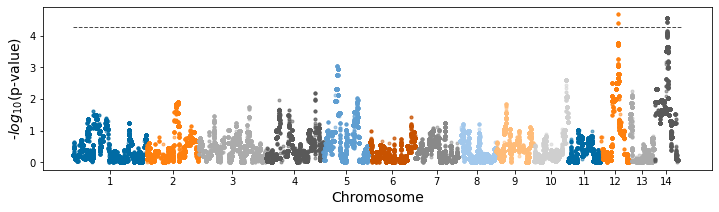

In [32]:
## Make a manhattan plot
fig,ax = plt.subplots(1,1,figsize=(12,3))
for c,chrom in enumerate(chrlist):
    tpd = pvaldf[(pvaldf.Chrom==chrom)]
    plt.plot(tpd.Pos+cumpos[c],tpd.Pval.values,'.',alpha=0.5);

plt.hlines(4.2589,0,19*(10**6),
           linestyle='--',alpha=0.7,
           linewidth=1,label=alpha_label,color='k')


plt.xticks(chrom_midpts,labels=np.arange(len(chrlist))+1);
plt.xlabel('Chromosome',fontsize=14);
plt.ylabel('-$log_{10}$(p-value)',fontsize=14);

In [33]:
## Gather qtl index for max asscoaiton at 
## Chromosomes 2, 12, and 14
ch02ix = pvaldf[(pvaldf.Chrom=='Chr02')].Pval.idxmax()
ch12ix = pvaldf[(pvaldf.Chrom=='Chr12')].Pval.idxmax()
ch14ix = pvaldf[(pvaldf.Chrom=='Chr14')].Pval.idxmax()

In [34]:
## Add genotypes at QTL peaks and chromosoem 2
medh2o2['Chr02'] = np.array(pvaldf.T[ch02ix][segs],dtype=float)
medh2o2['Chr12'] = np.array(pvaldf.T[ch12ix][segs],dtype=float)
medh2o2['Chr14'] = np.array(pvaldf.T[ch14ix][segs],dtype=float)

In [35]:
## Save data out for later use / analysis
medh2o2.to_csv('../DATA/PHENOTYPE/H2O2/H2O2_average_phenotypes.csv.gz',
               index=True)

In [36]:
## Check counds by allele combinations
medh2o2.groupby(['Chr12','Chr14']).count()

Column  Plate  Replicate  Score  Chr02
Chr12 Chr14                                        
0.0   0.0        24     24         24     24     24
      1.0        41     41         41     41     41
1.0   0.0        26     26         26     26     26
      1.0        13     13         13     13     13

In [37]:
## Gather parental data
parents = medh2o2.T[['SS-A837','XL280a']].T[['Score','Chr02']]

In [38]:
## Bring in other needed mods
import statsmodels.formula.api as smf

from matplotlib.gridspec import GridSpec
from PIL import Image


import matplotlib.image as mpimg
plt.style.use(['tableau-colorblind10'])

In [39]:
## Conduct regression analysis on chromosome 12 QTL
qtl12_res = smf.ols('Score~Chr12',data=medh2o2).fit()
qtl12_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     19.88
Date:                Thu, 10 Dec 2020   Prob (F-statistic):           2.12e-05
Time:                        14:29:01   Log-Likelihood:                -200.55
No. Observations:                 104   AIC:                             405.1
Df Residuals:                     102   BIC:                             410.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0077      0.208      9.631      0.000       1.594       2.421
Chr12          1.5179      0.340      4.459      0.000       0.843       2.193
==============================================================================
Omnibus:                       18.198   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.797
Skew:                          -0.038   Prob(JB):                       0.0909
Kurtosis:                       1.951   Cond. No.                         2.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
## Conduct regression on chromosome 14 QTL
qtl14_res = smf.ols('Score~Chr14',data=medh2o2).fit()
qtl14_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     19.23
Date:                Thu, 10 Dec 2020   Prob (F-statistic):           2.82e-05
Time:                        14:29:01   Log-Likelihood:                -200.83
No. Observations:                 104   AIC:                             405.7
Df Residuals:                     102   BIC:                             411.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3300      0.238     13.973      0.000       2.857       3.803
Chr14         -1.4504      0.331     -4.385      0.000      -2.106      -0.794
==============================================================================
Omnibus:                       16.080   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.637
Skew:                          -0.275   Prob(JB):                       0.0597
Kurtosis:                       2.001   Cond. No.                         2.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
## Test interactive modle
qtl12_14_res = smf.ols('Score~Chr12*Chr14',data=medh2o2).fit()
qtl12_14_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     13.55
Date:                Thu, 10 Dec 2020   Prob (F-statistic):           1.74e-07
Time:                        14:29:01   Log-Likelihood:                -192.08
No. Observations:                 104   AIC:                             392.2
Df Residuals:                     100   BIC:                             402.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.0729      0.319      9.622      0.000       2.439       3.707
Chr12           0.4944      0.443      1.116      0.267      -0.384       1.373
Chr14          -1.6888      0.402     -4.200      0.000      -2.487      -0.891
Chr12:Chr14     1.5638      0.666      2.346      0.021       0.242       2.886
==============================================================================
Omnibus:                        4.885   Durbin-Watson:                   1.621
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                3.436
Skew:                          -0.295   Prob(JB):                        0.179
Kurtosis:                       2.334   Cond. No.                         6.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
## Set chromosome colors
chrom_colors = ['tab:grey','tab:brown','lightgrey','salmon','tan']

In [43]:
## Conduct permutations
import os
kps = 10000
perms = []
perm_path = '../DATA/PERMUTATIONS/Cden_H2O2_permutations_null.csv.gz'
if not os.path.exists(perm_path):
    while len(perms)<kps:
    
        ran_pval = test[segs].apply(association_logPval,
                                args=[medh2o2.T[np.random.permutation(segs)].T.Score],
                                axis=1).max()
        perms.append(ran_pval)
    pd.DataFrame(perms,columns=['H2O2']).to_csv(perm_path,index=False)
else:
    perms = pd.read_csv(perm_path)['H2O2'].values
    
threshold_95 = np.percentile(perms,95)
threshold_95

4.258910961495085

In [44]:
## gather progeny
F_1 = [s for s in segs if s not in 
       ['XL80a','XL280alpha','SS-A837']]

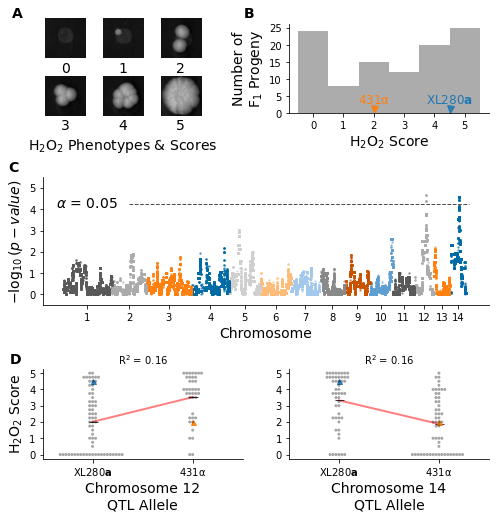

In [45]:
## Make figure 9
fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor('white')


gs = GridSpec(12,4,figure=fig)
ax_fake = fig.add_subplot(gs[:2,:2])
plt.sca(ax_fake)
[ax_fake.spines[s].set_visible(False) for s in ['top','right']]

plt.title(x=-0.125,y=1,label='A',
          fontsize=14,fontweight='bold')
plt.xticks([]);plt.yticks([])

[ax_fake.spines[j].set_visible(False) for j in ['top','bottom','left','right']]

ax_hist = fig.add_subplot(gs[:3,2:])

[ax_hist.spines[s].set_visible(False) for s in ['top','right']]


plt.hist(medh2o2.Score.values,color='grey',alpha=0.65,
         bins=np.arange(7)-0.5);

plt.xlabel('H$_{2}$O$_{2}$ Score',fontsize=14);
plt.xticks([0,1,2,3,4,5])
plt.ylabel('Number of\nF$_1$ Progeny',fontsize=14);
plt.yticks(np.arange(0,35,5))

#plt.vlines(medh2o2.T['XL280a'].T.Score,0,3.5,
#           alpha=0.75,linestyle='-',
#           color='tab:blue')#,label=_xl280alabel);
plt.plot(medh2o2.T['XL280a'].Score,1.2,'v',
         markersize=7,color='tab:blue',alpha=0.9)
plt.text(medh2o2.T['XL280a'].T.Score,3,
         _xl280alabel,fontsize=12,
         color='tab:blue',ha='center')

#plt.vlines(medh2o2.T['SS-A837'].T.Score,0,3.5,
#           alpha=0.75,color='tab:orange')#,label=_431label);
plt.plot(medh2o2.T['SS-A837'].Score,1.2,'v',
         markersize=7,color='tab:orange',alpha=0.9)
plt.text(medh2o2.T['SS-A837'].T.Score,3,
         _431label,fontsize=12,
         color='tab:orange',ha='center')

plt.title(x=-0.2,y=1,label='B',
          fontsize=14,fontweight='bold')

##### ----------------------------------------------------------###
ax_qtl1 = fig.add_subplot(gs[9:,:2])
[ax_qtl1.spines[s].set_visible(False) for s in ['top','right']]

## Plot regression and swarmplot
sns.regplot(x='Chr12',y='Score',
            data=medh2o2,ci=False,
            scatter_kws={'alpha':0.0},
            line_kws={'linewidth':2,'alpha':0.5,'color':'r'})
    
sns.swarmplot(x='Chr12',y='Score',
              data=medh2o2,size=3,
                rasterized=True,
                color='k',
                alpha=.35)

plt.plot(medh2o2.groupby('Chr12').mean()['Score'].index,
         medh2o2.groupby('Chr12').mean()['Score'].values,
         'k_',alpha=0.75,markersize=9)

plt.plot(*medh2o2.T['XL280a'][['Chr12','Score']],
         '^',color='tab:blue',alpha=.9,markersize=5)

plt.plot(*medh2o2.T['SS-A837'][['Chr12','Score']],
         '^',color='tab:orange',alpha=.9,markersize=5)

plt.ylabel(r'H$_{2}$O$_{2}$ Score',fontsize=14)
plt.yticks(np.arange(6))
plt.xticks([0,1],labels=[_xl280alabel,_431label])
plt.xlabel('Chromosome 12\nQTL Allele',fontsize=14)
plt.title(x=-0.135,y=1,label='D',
          fontsize=14,fontweight='bold')
plt.text(0.5,5.5,'R$^2$ = %s'%np.round(qtl12_res.rsquared,2),
        ha='center')
### -------------------------------------------------------------- ###
ax_qtl2 = fig.add_subplot(gs[9:,2:])
[ax_qtl2.spines[s].set_visible(False) for s in ['top','right']]

## Plot regression and swarmplot
sns.regplot(x='Chr14',y='Score',
            data=medh2o2,ci=False,
            scatter_kws={'alpha':0.0},
            line_kws={'linewidth':2,'alpha':0.5,'color':'r'})
    
sns.swarmplot(x='Chr14',y='Score',
              data=medh2o2,size=3,
                rasterized=True,
                color='k',
                alpha=.35)

plt.plot(medh2o2.groupby('Chr14').mean()['Score'].index,
         medh2o2.groupby('Chr14').mean()['Score'].values,
         'k_',alpha=0.75,markersize=9)

plt.plot(*medh2o2.T['XL280a'][['Chr14','Score']],
         '^',color='tab:blue',alpha=.9,markersize=5)

plt.plot(*medh2o2.T['SS-A837'][['Chr14','Score']],
         '^',color='tab:orange',alpha=.9,markersize=5)

plt.yticks(np.arange(6))
plt.ylabel('')
plt.xticks([0,1],labels=[_xl280alabel,_431label])
plt.xlabel('Chromosome 14\nQTL Allele',fontsize=14)
plt.text(0.5,5.5,'R$^2$ = %s'%np.round(qtl14_res.rsquared,2),
        ha='center')
### --------------------------- QTL MAPPING --------------------- ###

ax_qtl = fig.add_subplot(gs[4:8,:])

plt.sca(ax_qtl)
plt.title(x=-0.065,y=1,label='C',
          fontsize=14,fontweight='bold')

for c,chrom in enumerate(chrlist[::-1]):
    tpd = pvaldf[(pvaldf.Chrom==chrom)]
    c = 13 - c
    #if chrom == 'Chr12':
    #    cc = 'tab:orange'
    #elif chrom == 'Chr14':
    #    cc = 'tab:blue'
    #else:
    #    cc = chrom_colors[c%len(chrom_colors)]

    plt.plot(tpd.Pos+cumpos[c],tpd.Pval.values,'.',
             alpha=0.5,markersize=3);


plt.hlines(threshold_95,chrom_midpts[1],19*(10**6),
           linestyle='--',alpha=0.7,
           linewidth=1,label=alpha_label,color='k')

plt.xticks(chrom_midpts,labels=np.arange(len(chrlist))+1);
plt.xlabel('Chromosome',fontsize=14);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);

plt.ylim(-0.5,5.5)
plt.yticks([0,1,2,3,4,5])
##### ------------------------------------------------------ #####
plt.sca(ax_hist)
yw = 0.07
yh = 0.82
yh2 = 0.72
ax0 = fig.add_axes([0.13,yh,yw,yw])
pheno0 = '../IMAGES/H2O2_crop_segs/H2O2_0_crop.png'
pheno0_obj = Image.open(pheno0)
plt.imshow(pheno0_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'0',va='center',ha='center',
         transform=ax0.transAxes,fontsize=14)
plt.axis('off')
#plt.title(x=-2,y=2.35,label='A',
#          fontsize=14,fontweight='bold')

ax1 = fig.add_axes([0.23,yh,yw,yw])
pheno1 = '../IMAGES/H2O2_crop_segs/H2O2_1_crop.png'
pheno1_obj = Image.open(pheno1)
plt.imshow(pheno1_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'1',va='center',ha='center',
         transform=ax1.transAxes,fontsize=14)
plt.axis('off')
plt.title(x=0.5,y=-2.4,
          label=r'H$_{2}$O$_{2}$'+' Phenotypes & Scores',
         fontsize=14)
#plt.xlabel(r'H$_{2}$O$_{2}$'+' Phenotypes & Scores',fontsize=14)


ax2 = fig.add_axes([0.33,yh,yw,yw])
pheno2 = '../IMAGES/H2O2_crop_segs/H2O2_2_crop.png'
pheno2_obj = Image.open(pheno2)
plt.imshow(pheno2_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'2',va='center',ha='center',
         transform=ax2.transAxes,fontsize=14)
plt.axis('off')


#ax3 = fig.add_axes([0.25,.7,0.09,0.09])
ax3 = fig.add_axes([0.13,yh2,yw,yw])
plt.sca(ax3)

pheno3 = '../IMAGES/H2O2_crop_segs/H2O2_3_crop.png'
pheno3_obj = Image.open(pheno3)
plt.imshow(pheno3_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'3',va='center',ha='center',
         transform=ax3.transAxes,fontsize=14)
plt.axis('off')


ax4 = fig.add_axes([0.23,yh2,yw,yw])
pheno4 = '../IMAGES/H2O2_crop_segs/H2O2_4_crop.png'
pheno4_obj = Image.open(pheno4)
plt.imshow(pheno4_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'4',va='center',ha='center',
         transform=ax4.transAxes,fontsize=14)
plt.axis('off')


ax5 = fig.add_axes([0.33,yh2,yw,yw])
pheno5 = '../IMAGES/H2O2_crop_segs/H2O2_5_crop.png'
pheno5_obj = Image.open(pheno5)
plt.imshow(pheno5_obj, 
           cmap='gray', vmin=0, vmax=255);
plt.text(0.5,-0.25,'5',va='center',ha='center',
         transform=ax5.transAxes,fontsize=14)
plt.axis('off');


plt.sca(ax_qtl)
[ax_qtl.spines[s].set_visible(False) for s in ['top','right']]

plt.text(s = r'$\alpha$ = 0.05', x = chrom_midpts[0],y= threshold_95, 
         horizontalalignment='center',
         verticalalignment='center', 
         fontsize=14 )
        ## transform=ax_qtl.transAxes, 

plt.subplots_adjust(hspace=2,wspace=.6)
mydpi=600
plos_path = '../FIGURES/MAIN/TIFF/Fig9.tiff'
plt.savefig(plos_path,dpi=mydpi,bbox_inches='tight')
plt.savefig('../FIGURES/MAIN/PDFs/Fig9.pdf',
            dpi=mydpi,bbox_inches='tight',pad_inches=1)

im = Image.open(plos_path)
w,h = im.size
assert w/mydpi < 7.5
assert h/mydpi < 8

im.save(plos_path,compression='tiff_lzw');